# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 
import GPy
LIKELIHOOD_MODEL = 'likelihood-v1'
PREDICTION_MODEL = 'predict-v1'
sns.set(style="darkgrid")
np.random.seed(1)
train = pd.read_pickle('train.pkl')
route_n = 3 # all data used currently is from route 3
n_segs = train.seg.unique()
train.head()

def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data

## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [2]:

def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_data(synch_gp, seg)
    n_restarts = 5
    print('training', route_n, traj_n, seg_n)
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg, 
        ['tau'],
        ['lat', 'lon'],
        LIKELIHOOD_MODEL,
        route_n, 
        traj_n, 
        seg_n)
    #likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.05))
    #likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg, 
        ['tau'], 
        ['time_left'], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    #prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.005))
    #prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.05, 0.1))
    #prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.01, 0.005))
    gp.train(prediction_model, n_restarts)
    return likelihood_model, prediction_model

def train_traj_segs(traj, traj_n):
    n_segs = traj.seg.unique()
    return {seg_n: train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
          
n_trajs = train.traj.unique()
t0 = time.time()
traj_gps = {traj_n: train_traj_segs(train[train.traj == traj_n], traj_n) for traj_n in n_trajs}
dt = time.time() - t0
print("Data processed in", dt, " seconds")

training 3 1.0 2
Optimization restart 1/5, f = -544.552289851564
Optimization restart 2/5, f = -544.5522450942934
Optimization restart 3/5, f = -543.1658580630245
Optimization restart 4/5, f = -544.551798682276
Optimization restart 5/5, f = -544.5522792250747
Optimization restart 1/5, f = 95.92007042618694
Optimization restart 2/5, f = 95.920070426301
Optimization restart 3/5, f = 95.920070428184
Optimization restart 4/5, f = 95.92007042622063
Optimization restart 5/5, f = 95.92007042629342
training 3 1.0 3
Optimization restart 1/5, f = -580.3298729871226
Optimization restart 2/5, f = -595.8500816654886
Optimization restart 3/5, f = -580.3292793032742
Optimization restart 4/5, f = -580.3293583229852
Optimization restart 5/5, f = -595.8500871187621
Optimization restart 1/5, f = -14.15679532975981
Optimization restart 2/5, f = -14.156795331107297
Optimization restart 3/5, f = -3.0994643789430185
Optimization restart 4/5, f = -3.0994643791806027
Optimization restart 5/5, f = -14.156795332

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -805.6250530573751
Optimization restart 3/5, f = -789.3614363590602
Optimization restart 4/5, f = -789.3616578328713
Optimization restart 5/5, f = -805.6248568104348
Optimization restart 1/5, f = 123.22827393706521
Optimization restart 2/5, f = 116.26674199695921
Optimization restart 3/5, f = 116.26674176184245
Optimization restart 4/5, f = 116.26674176130712
Optimization restart 5/5, f = 116.26674179901266
training 3 1.0 8
Optimization restart 1/5, f = -364.7324393586117
Optimization restart 2/5, f = -364.73249706704075
Optimization restart 3/5, f = -364.73239654573365
Optimization restart 4/5, f = -364.73251151562823
Optimization restart 5/5, f = -364.7324791958396
Optimization restart 1/5, f = -1.704621852956972
Optimization restart 2/5, f = -21.016807465612644
Optimization restart 3/5, f = -1.7046218529389243
Optimization restart 4/5, f = -1.7046218529550963
Optimization restart 5/5, f = -1.7046218529936787
training 3 1.0 9
Optimization restart 1/5, f 

Optimization restart 5/5, f = -673.6077689477228
Optimization restart 1/5, f = 146.4521406456546
Optimization restart 2/5, f = 146.45214064616295
Optimization restart 3/5, f = 146.45214064568697
Optimization restart 4/5, f = 146.4521406459114
Optimization restart 5/5, f = 146.45214066119908
training 3 3.0 4
Optimization restart 1/5, f = -487.61422639924274
Optimization restart 2/5, f = -487.61395518414986
Optimization restart 3/5, f = -487.6141651699844
Optimization restart 4/5, f = -487.614102471866
Optimization restart 5/5, f = -487.61411966778724
Optimization restart 1/5, f = 76.7147509656531
Optimization restart 2/5, f = 76.7147509657172
Optimization restart 3/5, f = 76.71475096562341
Optimization restart 4/5, f = 76.714750965668
Optimization restart 5/5, f = 76.71475096568514
training 3 3.0 5
Optimization restart 1/5, f = -728.155892066348
Optimization restart 2/5, f = -728.1558859123982
Optimization restart 3/5, f = -728.155613943624
Optimization restart 4/5, f = -728.15570084012

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -746.8071608159328
Optimization restart 1/5, f = 127.73602029880396
Optimization restart 2/5, f = 127.73602029645666
Optimization restart 3/5, f = 127.7360202780506
Optimization restart 4/5, f = 127.73602028674055
Optimization restart 5/5, f = 127.73602027808585
training 3 3.0 8
Optimization restart 1/5, f = -397.8494513250573
Optimization restart 2/5, f = -381.14276050981465
Optimization restart 3/5, f = -397.8499634746445
Optimization restart 4/5, f = -397.84978624739114
Optimization restart 5/5, f = -397.8492705763124
Optimization restart 1/5, f = -16.299460573386316
Optimization restart 2/5, f = -16.29946057292165
Optimization restart 3/5, f = -16.299460566036892
Optimization restart 4/5, f = -16.299460573349293
Optimization restart 5/5, f = -16.29946057324299
training 3 3.0 9
Optimization restart 1/5, f = -1601.2070668037818
Optimization restart 2/5, f = -1601.3938809566564
Optimization restart 3/5, f = -1601.393802917406
Optimization restart 4/5, f =

Optimization restart 2/5, f = -506.12709206906123
Optimization restart 3/5, f = -506.1272078299107
Optimization restart 4/5, f = -506.12717552871385
Optimization restart 5/5, f = -506.1266243727352
Optimization restart 1/5, f = 88.62126594496462
Optimization restart 2/5, f = 88.62126592985317
Optimization restart 3/5, f = 88.62126593058264
Optimization restart 4/5, f = 94.01544385314212
Optimization restart 5/5, f = 88.62126592976068
training 3 6.0 5
Optimization restart 1/5, f = -826.6556204779571
Optimization restart 2/5, f = -826.655236397581
Optimization restart 3/5, f = -826.6547385268219
Optimization restart 4/5, f = -826.6555032877818
Optimization restart 5/5, f = -826.6556305277751
Optimization restart 1/5, f = 89.81654950477257
Optimization restart 2/5, f = 89.81654950413268
Optimization restart 3/5, f = 89.8165495041526
Optimization restart 4/5, f = 89.8165495041876
Optimization restart 5/5, f = 89.81654950413302
training 3 6.0 6
Optimization restart 1/5, f = -728.32802980436

Optimization restart 2/5, f = 77.94714650169682
Optimization restart 3/5, f = 78.00837715076133
Optimization restart 4/5, f = 78.00837715075427
Optimization restart 5/5, f = 77.94714650450388
training 3 8.0 11
Optimization restart 1/5, f = -649.1994834663614
Optimization restart 2/5, f = -649.1996334325094
Optimization restart 3/5, f = -649.199580110626
Optimization restart 4/5, f = -649.1994973236513
Optimization restart 5/5, f = -649.1995546550559
Optimization restart 1/5, f = 98.29024816397975
Optimization restart 2/5, f = 98.29024816383355
Optimization restart 3/5, f = 98.29024816332483
Optimization restart 4/5, f = 98.29024816332574
Optimization restart 5/5, f = 98.29024816332566
training 3 9.0 2
Optimization restart 1/5, f = -529.4393047957038
Optimization restart 2/5, f = -529.4397928142436
Optimization restart 3/5, f = -527.8774427653628
Optimization restart 4/5, f = -527.877367522278
Optimization restart 5/5, f = -529.439445548372
Optimization restart 1/5, f = 79.0500650460618

Optimization restart 2/5, f = -805.1093758436148
Optimization restart 3/5, f = -821.9168883301942
Optimization restart 4/5, f = -805.1092643310866
Optimization restart 5/5, f = -821.9171440078942
Optimization restart 1/5, f = 107.46538882405804
Optimization restart 2/5, f = 107.46538880880979
Optimization restart 3/5, f = 107.46538880849896
Optimization restart 4/5, f = 107.46538880853988
Optimization restart 5/5, f = 107.4653888085434
training 3 10.0 8
Optimization restart 1/5, f = -478.3258617687939
Optimization restart 2/5, f = -478.32580839998326
Optimization restart 3/5, f = -478.325845281472
Optimization restart 4/5, f = -478.3258364332642
Optimization restart 5/5, f = -478.3258896163638
Optimization restart 1/5, f = 94.42770493889319
Optimization restart 2/5, f = 94.4277049318014
Optimization restart 3/5, f = 91.51673967577926
Optimization restart 4/5, f = 91.51673967333801
Optimization restart 5/5, f = 94.42770493255045
training 3 10.0 9
Optimization restart 1/5, f = -1521.5943

Optimization restart 2/5, f = 125.51178182389627
Optimization restart 3/5, f = 125.51178182393238
Optimization restart 4/5, f = 125.51178182452855
Optimization restart 5/5, f = 125.51178182449179
training 3 13.0 4
Optimization restart 1/5, f = -455.3228021029277
Optimization restart 2/5, f = -455.3227437167299
Optimization restart 3/5, f = -455.3228237047941
Optimization restart 4/5, f = -455.32281880921204
Optimization restart 5/5, f = -455.32284025755615
Optimization restart 1/5, f = 89.35460549335139
Optimization restart 2/5, f = 89.35460549331457
Optimization restart 3/5, f = 89.35460553878761
Optimization restart 4/5, f = 89.35460549351208
Optimization restart 5/5, f = 89.3546054933115
training 3 13.0 5
Optimization restart 1/5, f = -811.4253943615475
Optimization restart 2/5, f = -811.4253446372707
Optimization restart 3/5, f = -811.4252351851798
Optimization restart 4/5, f = -811.4253464304898
Optimization restart 5/5, f = -811.4256077603228
Optimization restart 1/5, f = 132.677

Optimization restart 1/5, f = -679.0198711909203
Optimization restart 2/5, f = -676.4476670430065
Optimization restart 3/5, f = -679.0216598768459
Optimization restart 4/5, f = -676.4476238564499
Optimization restart 5/5, f = -676.447651304432
Optimization restart 1/5, f = 68.3144110777666
Optimization restart 2/5, f = 68.31441107770624
Optimization restart 3/5, f = 68.31441107774694
Optimization restart 4/5, f = 68.31441107807375
Optimization restart 5/5, f = 68.31441107769069
training 3 14.0 11
Optimization restart 1/5, f = -679.1336812951595
Optimization restart 2/5, f = -679.1339118891412
Optimization restart 3/5, f = -679.1339834970031
Optimization restart 4/5, f = -679.1338315013036
Optimization restart 5/5, f = -679.1332044269966
Optimization restart 1/5, f = 107.34732126331491
Optimization restart 2/5, f = 107.34732126490078
Optimization restart 3/5, f = 107.3473212633261
Optimization restart 4/5, f = 107.34732144550031
Optimization restart 5/5, f = 107.34732126332403
training 

Optimization restart 4/5, f = 85.09758224179207
Optimization restart 5/5, f = 85.09758224135975
training 3 18.0 7
Optimization restart 1/5, f = -765.3847435575759
Optimization restart 2/5, f = -765.38486323806
Optimization restart 3/5, f = -776.2709967261468
Optimization restart 4/5, f = -765.3848676538264
Optimization restart 5/5, f = -765.3850261827766
Optimization restart 1/5, f = 141.50695369335733
Optimization restart 2/5, f = 141.50695369337296
Optimization restart 3/5, f = 141.5069536933707
Optimization restart 4/5, f = 141.50695369660494
Optimization restart 5/5, f = 141.50695369348716
training 3 18.0 8
Optimization restart 1/5, f = -494.83613701762465
Optimization restart 2/5, f = -494.1709171312259
Optimization restart 3/5, f = -494.8361167455173
Optimization restart 4/5, f = -494.836125751945
Optimization restart 5/5, f = -494.8360888636182
Optimization restart 1/5, f = 82.37728784777217
Optimization restart 2/5, f = 82.37728784280091
Optimization restart 3/5, f = 82.3772878

Optimization restart 1/5, f = -483.0709596005238
Optimization restart 2/5, f = -471.10071268393597
Optimization restart 3/5, f = -483.0707785172127
Optimization restart 4/5, f = -483.07084018078456
Optimization restart 5/5, f = -471.1007375591611
Optimization restart 1/5, f = -22.55574025787061
Optimization restart 2/5, f = -22.555740258173216
Optimization restart 3/5, f = 7.008506428700176
Optimization restart 4/5, f = -22.5557402574959
Optimization restart 5/5, f = 7.0085064287055445
training 3 23.0 4
Optimization restart 1/5, f = -488.8162583997015
Optimization restart 2/5, f = -488.81642683090206
Optimization restart 3/5, f = -488.81635783971274
Optimization restart 4/5, f = -488.81634221614377
Optimization restart 5/5, f = -488.81638173664726
Optimization restart 1/5, f = 76.45479986825889
Optimization restart 2/5, f = 76.45479986795056
Optimization restart 3/5, f = 139.39341061174596
Optimization restart 4/5, f = 76.45479986797827
Optimization restart 5/5, f = 76.45479986842737
t

Optimization restart 4/5, f = -1579.225526940067
Optimization restart 5/5, f = -1831.3544285747178
Optimization restart 1/5, f = 236.27943550246317
Optimization restart 2/5, f = 236.2794355002805
Optimization restart 3/5, f = 236.2794355014767
Optimization restart 4/5, f = 236.27943550113386
Optimization restart 5/5, f = 236.27943550030267
training 3 24.0 10
Optimization restart 1/5, f = -696.0432922447746
Optimization restart 2/5, f = -693.6121638463075
Optimization restart 3/5, f = -696.0429777379725
Optimization restart 4/5, f = -693.6121632949046
Optimization restart 5/5, f = -693.6121983138787
Optimization restart 1/5, f = 70.6949242274727
Optimization restart 2/5, f = 70.69492422836618
Optimization restart 3/5, f = 70.69492422755854
Optimization restart 4/5, f = 70.69492422751912
Optimization restart 5/5, f = 70.69492422745883
training 3 24.0 11
Optimization restart 1/5, f = -665.4854101482767
Optimization restart 2/5, f = -665.4855824289372
Optimization restart 3/5, f = -665.485

Optimization restart 1/5, f = 12.6597990397213
Optimization restart 2/5, f = 12.659799039212007
Optimization restart 3/5, f = 12.659799038786666
Optimization restart 4/5, f = 11.393032135015673
Optimization restart 5/5, f = 12.659799039417027
training 3 26.0 6
Optimization restart 1/5, f = -619.4125352583453
Optimization restart 2/5, f = -619.41225007295
Optimization restart 3/5, f = -619.4120514265051
Optimization restart 4/5, f = -619.412215927817
Optimization restart 5/5, f = -656.5830407346782
Optimization restart 1/5, f = 79.3209842134733
Optimization restart 2/5, f = 79.3209842135641
Optimization restart 3/5, f = 79.32098421349991
Optimization restart 4/5, f = 79.32098421412127
Optimization restart 5/5, f = 79.32098421351373
training 3 26.0 7
Optimization restart 1/5, f = -858.8156480342365
Optimization restart 2/5, f = -854.9624949279524
Optimization restart 3/5, f = -860.5196248166088
Optimization restart 4/5, f = -860.5197543247074
Optimization restart 5/5, f = -860.5194401489

Optimization restart 1/5, f = -510.46576635126894
Optimization restart 2/5, f = -513.2145035186084
Optimization restart 3/5, f = -513.2143204235224
Optimization restart 4/5, f = -510.46579255766585
Optimization restart 5/5, f = -513.2139043067643
Optimization restart 1/5, f = 100.46621963066994
Optimization restart 2/5, f = 100.46621963067467
Optimization restart 3/5, f = 100.46621964987705
Optimization restart 4/5, f = 100.46621963078469
Optimization restart 5/5, f = 100.4662196350111
training 3 30.0 3
Optimization restart 1/5, f = -542.1224007305595
Optimization restart 2/5, f = -578.2688730440328
Optimization restart 3/5, f = -578.269081018972
Optimization restart 4/5, f = -542.1215867630062
Optimization restart 5/5, f = -578.2691042262362
Optimization restart 1/5, f = 82.54926134409016
Optimization restart 2/5, f = 82.54926134403526
Optimization restart 3/5, f = 82.54926134410984
Optimization restart 4/5, f = 82.54926134404938
Optimization restart 5/5, f = 82.54926134498271
trainin

Optimization restart 4/5, f = -408.9773938635869
Optimization restart 5/5, f = -408.97743147739976
Optimization restart 1/5, f = 24.47027136549152
Optimization restart 2/5, f = 24.470271367350648
Optimization restart 3/5, f = 54.3077015189601
Optimization restart 4/5, f = 24.47027137294325
Optimization restart 5/5, f = 24.470271365753415
training 3 33.0 9
Optimization restart 1/5, f = -1482.9923755204536
Optimization restart 2/5, f = -1482.992406296705
Optimization restart 3/5, f = -1482.8341844464312
Optimization restart 4/5, f = -1716.828629784797
Optimization restart 5/5, f = -1482.992287067774
Optimization restart 1/5, f = 211.1903977413172
Optimization restart 2/5, f = 211.19039774028874
Optimization restart 3/5, f = 211.19039776355774
Optimization restart 4/5, f = 211.19039774020627
Optimization restart 5/5, f = 211.19039774020388
training 3 33.0 10
Optimization restart 1/5, f = -687.8052067757329
Optimization restart 2/5, f = -692.3831866110363
Optimization restart 3/5, f = -687

Optimization restart 5/5, f = 9.387820524248873
training 3 36.0 5
Optimization restart 1/5, f = -649.8819743482982
Optimization restart 2/5, f = -649.8825660534571
Optimization restart 3/5, f = -647.9573571258106
Optimization restart 4/5, f = -649.8819725148428
Optimization restart 5/5, f = -649.8824430283389
Optimization restart 1/5, f = 48.741817854615974
Optimization restart 2/5, f = 48.74181785464465
Optimization restart 3/5, f = 48.74181785463521
Optimization restart 4/5, f = 48.74181785462196
Optimization restart 5/5, f = 48.741817854792494
training 3 36.0 6
Optimization restart 1/5, f = -525.4257966439941
Optimization restart 2/5, f = -495.08300930189023
Optimization restart 3/5, f = -525.4257726381584
Optimization restart 4/5, f = -525.4257933679199
Optimization restart 5/5, f = -495.0834881762953
Optimization restart 1/5, f = 43.3049295786755
Optimization restart 2/5, f = 43.3049295621574
Optimization restart 3/5, f = 43.30492957745179
Optimization restart 4/5, f = 42.32363274

Optimization restart 4/5, f = -584.0447001114181
Optimization restart 5/5, f = -584.0446852732467
Optimization restart 1/5, f = 29.44317928802091
Optimization restart 2/5, f = 29.443179288032052
Optimization restart 3/5, f = 29.443179288031256
Optimization restart 4/5, f = 29.44317928862201
Optimization restart 5/5, f = 29.443179288020527
training 3 41.0 2
Optimization restart 1/5, f = -526.7275494443575
Optimization restart 2/5, f = -527.6829301922392
Optimization restart 3/5, f = -527.6826779183092
Optimization restart 4/5, f = -527.6825841394433
Optimization restart 5/5, f = -527.6829395012547
Optimization restart 1/5, f = 91.3262171749875
Optimization restart 2/5, f = 91.326217170705
Optimization restart 3/5, f = 91.3262171717279
Optimization restart 4/5, f = 91.3262171706895
Optimization restart 5/5, f = 91.32621717066613
training 3 41.0 3
Optimization restart 1/5, f = -583.2762887947721
Optimization restart 2/5, f = -583.4560679610005
Optimization restart 3/5, f = -583.2756467932

Optimization restart 3/5, f = 162.94292359289548
Optimization restart 4/5, f = 162.94292358293222
Optimization restart 5/5, f = 167.80853076180074
training 3 42.0 8
Optimization restart 1/5, f = -511.6987489143139
Optimization restart 2/5, f = -519.5760903754099
Optimization restart 3/5, f = -519.5756680404447
Optimization restart 4/5, f = -519.575731155035
Optimization restart 5/5, f = -519.5754594477387
Optimization restart 1/5, f = 68.92776638719957
Optimization restart 2/5, f = 68.92776638797878
Optimization restart 3/5, f = 68.32539696320323
Optimization restart 4/5, f = 68.32539696318308
Optimization restart 5/5, f = 68.32539696324886
training 3 42.0 9
Optimization restart 1/5, f = -1571.105704444574
Optimization restart 2/5, f = -1571.1057782428816
Optimization restart 3/5, f = -1571.1056586465372
Optimization restart 4/5, f = -1571.1057326456826
Optimization restart 5/5, f = -1571.1057211305867
Optimization restart 1/5, f = 317.1450432756249
Optimization restart 2/5, f = 317.14

Optimization restart 3/5, f = -473.02665902332785
Optimization restart 4/5, f = -473.02661223056487
Optimization restart 5/5, f = -473.02674802930596
Optimization restart 1/5, f = 75.92116157320075
Optimization restart 2/5, f = 75.92116157258367
Optimization restart 3/5, f = 75.92116157272855
Optimization restart 4/5, f = 75.92116157260057
Optimization restart 5/5, f = 75.92116157258869
training 3 49.0 5
Optimization restart 1/5, f = -743.2052678114975
Optimization restart 2/5, f = -743.2053052562582
Optimization restart 3/5, f = -743.2052898123312
Optimization restart 4/5, f = -743.2052770462591
Optimization restart 5/5, f = -743.2052776125939
Optimization restart 1/5, f = 125.043637748019
Optimization restart 2/5, f = 115.53633480585191
Optimization restart 3/5, f = 115.53633480792095
Optimization restart 4/5, f = 125.04363774944474
Optimization restart 5/5, f = 115.5363348058554
training 3 49.0 6
Optimization restart 1/5, f = -525.4971413959726
Optimization restart 2/5, f = -501.534

Optimization restart 1/5, f = 115.75156939386972
Optimization restart 2/5, f = 67.63431287863865
Optimization restart 3/5, f = 115.75156936771735
Optimization restart 4/5, f = 67.63431287868136
Optimization restart 5/5, f = 67.63431287858023
training 3 50.0 11
Optimization restart 1/5, f = -682.3269735723136
Optimization restart 2/5, f = -682.3270749155556
Optimization restart 3/5, f = -682.3271371230508
Optimization restart 4/5, f = -682.3270723772546
Optimization restart 5/5, f = -682.3271311505621
Optimization restart 1/5, f = 64.536038220011
Optimization restart 2/5, f = 64.53603829643134
Optimization restart 3/5, f = 64.53603821906636
Optimization restart 4/5, f = 64.53603821904535
Optimization restart 5/5, f = 64.53603821895072
training 3 51.0 2
Optimization restart 1/5, f = -610.5320101224851
Optimization restart 2/5, f = -610.5318917759687
Optimization restart 3/5, f = -610.5324978909712
Optimization restart 4/5, f = -610.5318097365848
Optimization restart 5/5, f = -609.3040780

training 3 52.0 7
Optimization restart 1/5, f = -772.8465702075797
Optimization restart 2/5, f = -756.4761426924553
Optimization restart 3/5, f = -756.4765740987073
Optimization restart 4/5, f = -756.4764118660827
Optimization restart 5/5, f = -772.8464920819434
Optimization restart 1/5, f = 126.99310005047234
Optimization restart 2/5, f = 137.42768005088612
Optimization restart 3/5, f = 129.2102725587507
Optimization restart 4/5, f = 126.99310053174419
Optimization restart 5/5, f = 137.42768005095306
training 3 52.0 8
Optimization restart 1/5, f = -395.93526043576907
Optimization restart 2/5, f = -380.82023920818983
Optimization restart 3/5, f = -395.9353843315768
Optimization restart 4/5, f = -380.8202820793926
Optimization restart 5/5, f = -395.93515098341146
Optimization restart 1/5, f = -14.980655640632651
Optimization restart 2/5, f = -14.98065564219655
Optimization restart 3/5, f = -14.980655641855504
Optimization restart 4/5, f = -14.980655641863068
Optimization restart 5/5, f 

Optimization restart 3/5, f = -708.7600657696947
Optimization restart 4/5, f = -672.3312901851048
Optimization restart 5/5, f = -672.3291983851487
Optimization restart 1/5, f = 88.56778105585825
Optimization restart 2/5, f = 88.56778105601617
Optimization restart 3/5, f = 88.56778105588329
Optimization restart 4/5, f = 88.567781069484
Optimization restart 5/5, f = 88.56778105596396
training 3 55.0 4
Optimization restart 1/5, f = -488.05371027383717
Optimization restart 2/5, f = -488.05360896511047
Optimization restart 3/5, f = -488.05367627106045
Optimization restart 4/5, f = -488.05349432648825
Optimization restart 5/5, f = -488.05365958415655
Optimization restart 1/5, f = 78.98363079377637
Optimization restart 2/5, f = 78.98363078514143
Optimization restart 3/5, f = 78.98363078514163
Optimization restart 4/5, f = 78.98363078705708
Optimization restart 5/5, f = 78.98363078514065
training 3 55.0 5
Optimization restart 1/5, f = -649.2304186577537
Optimization restart 2/5, f = -649.14739

Optimization restart 1/5, f = 320.2971620801035
Optimization restart 2/5, f = 320.29716208112785
Optimization restart 3/5, f = 439.47259022983326
Optimization restart 4/5, f = 320.2971620799865
Optimization restart 5/5, f = 320.2971620800494
training 3 56.0 10
Optimization restart 1/5, f = -631.8695536431887
Optimization restart 2/5, f = -631.8682702441391
Optimization restart 3/5, f = -627.1250442403328
Optimization restart 4/5, f = -627.1250756653878
Optimization restart 5/5, f = -631.8691449494708
Optimization restart 1/5, f = 65.38271146012849
Optimization restart 2/5, f = 65.38271146015774
Optimization restart 3/5, f = 65.3827114602568
Optimization restart 4/5, f = 65.38271146012933
Optimization restart 5/5, f = 65.38271146025522
training 3 56.0 11
Optimization restart 1/5, f = -567.8221753990769
Optimization restart 2/5, f = -567.8219321801171
Optimization restart 3/5, f = -567.8219209480789
Optimization restart 4/5, f = -567.8220120484123
Optimization restart 5/5, f = -567.82192

Optimization restart 4/5, f = 122.09509688859646
Optimization restart 5/5, f = 122.0950969322965
training 3 60.0 6
Optimization restart 1/5, f = -599.7351021586675
Optimization restart 2/5, f = -639.9945751350183
Optimization restart 3/5, f = -599.7351133749573
Optimization restart 4/5, f = -599.7353685200932
Optimization restart 5/5, f = -599.7351615096344
Optimization restart 1/5, f = 121.93784204447867
Optimization restart 2/5, f = 121.9378419435698
Optimization restart 3/5, f = 121.93784194352261
Optimization restart 4/5, f = 121.93784194375269
Optimization restart 5/5, f = 138.7358870494333
training 3 60.0 7
Optimization restart 1/5, f = -748.6682094769716
Optimization restart 2/5, f = -748.6678352624515
Optimization restart 3/5, f = -748.6682842344688
Optimization restart 4/5, f = -748.6581279592738
Optimization restart 5/5, f = -748.6680001414385
Optimization restart 1/5, f = 138.8161777340311
Optimization restart 2/5, f = 138.81617773393282
Optimization restart 3/5, f = 138.816

Optimization restart 2/5, f = -562.2751774885223
Optimization restart 3/5, f = -559.9196257248133
Optimization restart 4/5, f = -562.2754320987883
Optimization restart 5/5, f = -562.2753831105603
Optimization restart 1/5, f = 128.192033190481
Optimization restart 2/5, f = 128.19203319053838
Optimization restart 3/5, f = 128.1920331904921
Optimization restart 4/5, f = 128.19203319518405
Optimization restart 5/5, f = 128.19203319048
training 3 62.0 3
Optimization restart 1/5, f = -638.895225972871
Optimization restart 2/5, f = -675.018041196858
Optimization restart 3/5, f = -675.8247023480874
Optimization restart 4/5, f = -675.8248239249151
Optimization restart 5/5, f = -675.8246638951887
Optimization restart 1/5, f = 94.67324214545413
Optimization restart 2/5, f = 94.67324214067887
Optimization restart 3/5, f = 94.6732421400237
Optimization restart 4/5, f = 94.67324214097425
Optimization restart 5/5, f = 94.67324215978348
training 3 62.0 4
Optimization restart 1/5, f = -472.565275517894

Optimization restart 4/5, f = 83.85097222155018
Optimization restart 5/5, f = 83.41562219366047
training 3 65.0 9
Optimization restart 1/5, f = -1786.8665288570835
Optimization restart 2/5, f = -1786.8662097845825
Optimization restart 3/5, f = -1874.8192278814156
Optimization restart 4/5, f = -1786.8662956961973
Optimization restart 5/5, f = -1874.8198141382152
Optimization restart 1/5, f = 99.43093126370226
Optimization restart 2/5, f = 99.43093126392228
Optimization restart 3/5, f = 99.43093126413866
Optimization restart 4/5, f = 99.43093126365542
Optimization restart 5/5, f = 99.43093126368431
training 3 65.0 10
Optimization restart 1/5, f = -757.179903968352
Optimization restart 2/5, f = -754.1391990402501
Optimization restart 3/5, f = -758.7876621779934
Optimization restart 4/5, f = -758.7876391704091
Optimization restart 5/5, f = -754.1392888171304
Optimization restart 1/5, f = 36.2780526837896
Optimization restart 2/5, f = 36.27805268382138
Optimization restart 3/5, f = 36.27805

Optimization restart 2/5, f = -697.4694038486059
Optimization restart 3/5, f = -697.4695774273273
Optimization restart 4/5, f = -697.4694761290809
Optimization restart 5/5, f = -697.4694623799749
Optimization restart 1/5, f = 22.87209929269606
Optimization restart 2/5, f = 22.872099292788345
Optimization restart 3/5, f = 22.87209929279131
Optimization restart 4/5, f = 22.872099307316308
Optimization restart 5/5, f = 22.872099293758417
training 3 67.0 6
Optimization restart 1/5, f = -664.8416573538104
Optimization restart 2/5, f = -664.8409028185413
Optimization restart 3/5, f = -664.8414182449221
Optimization restart 4/5, f = -664.8413649679239
Optimization restart 5/5, f = -706.2195702577997
Optimization restart 1/5, f = 36.72384002983149
Optimization restart 2/5, f = 36.72384002980145
Optimization restart 3/5, f = 36.72384002979864
Optimization restart 4/5, f = 36.723840029955234
Optimization restart 5/5, f = 36.72384002979918
training 3 67.0 7
Optimization restart 1/5, f = -845.7687

Optimization restart 4/5, f = 74.4126956824676
Optimization restart 5/5, f = 74.41269568209051
training 3 69.0 2
Optimization restart 1/5, f = -670.5730005503391
Optimization restart 2/5, f = -670.5724156237931
Optimization restart 3/5, f = -670.5727972962403
Optimization restart 4/5, f = -670.5733308816463
Optimization restart 5/5, f = -670.5731108493447
Optimization restart 1/5, f = 133.17899521030748
Optimization restart 2/5, f = 133.17899496539687
Optimization restart 3/5, f = 133.1789949962905
Optimization restart 4/5, f = 134.0841643021435
Optimization restart 5/5, f = 133.17899496518348
training 3 69.0 3
Optimization restart 1/5, f = -629.4297458222578
Optimization restart 2/5, f = -663.0269272807873
Optimization restart 3/5, f = -663.0269386767745
Optimization restart 4/5, f = -663.0270223519979
Optimization restart 5/5, f = -629.4305798858704
Optimization restart 1/5, f = 72.00283251098277
Optimization restart 2/5, f = 72.00283251132693
Optimization restart 3/5, f = 72.0028325

Optimization restart 2/5, f = -576.0017986778381
Optimization restart 3/5, f = -577.3636051160005
Optimization restart 4/5, f = -577.3636565244958
Optimization restart 5/5, f = -577.3636107259416
Optimization restart 1/5, f = 79.20114852399273
Optimization restart 2/5, f = 79.20114852395531
Optimization restart 3/5, f = 79.20114852584156
Optimization restart 4/5, f = 79.20114852392106
Optimization restart 5/5, f = 79.20114852399591
training 3 70.0 9
Optimization restart 1/5, f = -1665.404974323998
Optimization restart 2/5, f = -1665.4043469286967
Optimization restart 3/5, f = -1665.4047800031194
Optimization restart 4/5, f = -1665.4058158566772
Optimization restart 5/5, f = -1942.633310201691
Optimization restart 1/5, f = 187.7805422785426
Optimization restart 2/5, f = 187.78054228018166
Optimization restart 3/5, f = 187.7805422787378
Optimization restart 4/5, f = 187.78054240265212
Optimization restart 5/5, f = 187.78054243326864
training 3 70.0 10
Optimization restart 1/5, f = -680.4

Optimization restart 1/5, f = 47.23430995018772
Optimization restart 2/5, f = 47.23430994900333
Optimization restart 3/5, f = 47.23430995021419
Optimization restart 4/5, f = 47.234309949139785
Optimization restart 5/5, f = 55.60428084349393
training 3 73.0 5
Optimization restart 1/5, f = -795.1375144364673
Optimization restart 2/5, f = -791.706167078901
Optimization restart 3/5, f = -795.1375544402936
Optimization restart 4/5, f = -795.1377594814402
Optimization restart 5/5, f = -795.1376565384351
Optimization restart 1/5, f = 88.4354813330881
Optimization restart 2/5, f = 88.43548133337252
Optimization restart 3/5, f = 88.43548133443538
Optimization restart 4/5, f = 88.43548133306224
Optimization restart 5/5, f = 88.43548133306669
training 3 73.0 6
Optimization restart 1/5, f = -619.6225436150005
Optimization restart 2/5, f = -619.6222459041528
Optimization restart 3/5, f = -655.9585249240097
Optimization restart 4/5, f = -655.9585124089303
Optimization restart 5/5, f = -619.622277411

Optimization restart 4/5, f = 103.29878767049973
Optimization restart 5/5, f = 103.29878767056647
training 3 75.0 11
Optimization restart 1/5, f = -519.3715687419237
Optimization restart 2/5, f = -519.3714740696837
Optimization restart 3/5, f = -519.371627293879
Optimization restart 4/5, f = -519.371601621571
Optimization restart 5/5, f = -519.3715125935098
Optimization restart 1/5, f = -15.926263717083131
Optimization restart 2/5, f = -15.92626371927184
Optimization restart 3/5, f = -15.92626371489147
Optimization restart 4/5, f = -15.92626371705208
Optimization restart 5/5, f = -15.926263717987261
training 3 76.0 2
Optimization restart 1/5, f = -607.9511339793593
Optimization restart 2/5, f = -609.8159969006397
Optimization restart 3/5, f = -607.9516014079878
Optimization restart 4/5, f = -607.9522492775868
Optimization restart 5/5, f = -609.8160174460961
Optimization restart 1/5, f = 101.61385952466158
Optimization restart 2/5, f = 101.61385951917214
Optimization restart 3/5, f = 10

Optimization restart 5/5, f = -821.5533993075009
Optimization restart 1/5, f = 123.6195411431548
Optimization restart 2/5, f = 123.61954114377968
Optimization restart 3/5, f = 124.16340838320025
Optimization restart 4/5, f = 123.61954115450848
Optimization restart 5/5, f = 123.61954114340354
training 3 79.0 8
Optimization restart 1/5, f = -383.318023302126
Optimization restart 2/5, f = -383.3189761833253
Optimization restart 3/5, f = -383.3193361309475
Optimization restart 4/5, f = -383.3193406410944
Optimization restart 5/5, f = -383.31914428834233
Optimization restart 1/5, f = -14.128740393771123
Optimization restart 2/5, f = -14.12874039327102
Optimization restart 3/5, f = -14.128740393535027
Optimization restart 4/5, f = -14.128740393712981
Optimization restart 5/5, f = -14.128740393418184
training 3 79.0 9
Optimization restart 1/5, f = -1363.5393534840348
Optimization restart 2/5, f = -1363.539345645112
Optimization restart 3/5, f = -1363.539315770517
Optimization restart 4/5, f =

Optimization restart 5/5, f = 65.47399149153028
training 3 92.0 4
Optimization restart 1/5, f = -404.569861005589
Optimization restart 2/5, f = -404.5698060504008
Optimization restart 3/5, f = -404.56978400600485
Optimization restart 4/5, f = -404.56983463744353
Optimization restart 5/5, f = -404.5697605587194
Optimization restart 1/5, f = 24.08705522073442
Optimization restart 2/5, f = 24.087055220726597
Optimization restart 3/5, f = 24.0870552211661
Optimization restart 4/5, f = 24.087055220742798
Optimization restart 5/5, f = 24.08705522073447
training 3 92.0 5
Optimization restart 1/5, f = -728.0812668310919
Optimization restart 2/5, f = -728.0818999592666
Optimization restart 3/5, f = -728.0820347713818
Optimization restart 4/5, f = -728.0818385822396
Optimization restart 5/5, f = -728.0819449547648
Optimization restart 1/5, f = 39.42994648803813
Optimization restart 2/5, f = 39.42994648789097
Optimization restart 3/5, f = 39.42994648863346
Optimization restart 4/5, f = 44.1584833

Optimization restart 4/5, f = -622.2003717048416
Optimization restart 5/5, f = -622.1996534022372
Optimization restart 1/5, f = 67.16375548124888
Optimization restart 2/5, f = 67.16375553368641
Optimization restart 3/5, f = 67.16375548153313
Optimization restart 4/5, f = 67.16375748385177
Optimization restart 5/5, f = 67.16375548123804
training 3 93.0 11
Optimization restart 1/5, f = -680.78795039179
Optimization restart 2/5, f = -680.7872423182384
Optimization restart 3/5, f = -680.7879649947756
Optimization restart 4/5, f = -680.7876376890524
Optimization restart 5/5, f = -680.7882673122986
Optimization restart 1/5, f = 72.92193196588302
Optimization restart 2/5, f = 72.92193203842703
Optimization restart 3/5, f = 72.92193196585951
Optimization restart 4/5, f = 72.92193196942584
Optimization restart 5/5, f = 72.92193196585205
training 3 94.0 2
Optimization restart 1/5, f = -562.1817878199689
Optimization restart 2/5, f = -560.657091377023
Optimization restart 3/5, f = -562.1820720086

training 3 97.0 7
Optimization restart 1/5, f = -879.1683471189444
Optimization restart 2/5, f = -879.1682647899515
Optimization restart 3/5, f = -879.1688525190928
Optimization restart 4/5, f = -879.168320167618
Optimization restart 5/5, f = -899.3647308537827
Optimization restart 1/5, f = 120.82964089746879
Optimization restart 2/5, f = 120.82964089752649
Optimization restart 3/5, f = 120.82964089760702
Optimization restart 4/5, f = 120.82964090014681
Optimization restart 5/5, f = 120.82964089745825
training 3 97.0 8
Optimization restart 1/5, f = -478.53659004588854
Optimization restart 2/5, f = -478.5366394515309
Optimization restart 3/5, f = -487.20503747508377
Optimization restart 4/5, f = -478.5365882393493
Optimization restart 5/5, f = -478.53663930390763
Optimization restart 1/5, f = 64.84147493637192
Optimization restart 2/5, f = 64.84147493609177
Optimization restart 3/5, f = 64.84147493613274
Optimization restart 4/5, f = 64.84147493609349
Optimization restart 5/5, f = 64.84

Optimization restart 3/5, f = 132.35631796389794
Optimization restart 4/5, f = 132.35631778657225
Optimization restart 5/5, f = 132.35631778992828
training 3 104.0 4
Optimization restart 1/5, f = -488.77262508602837
Optimization restart 2/5, f = -488.77252344805845
Optimization restart 3/5, f = -488.7726624905604
Optimization restart 4/5, f = -488.7725794613623
Optimization restart 5/5, f = -488.77265294983783
Optimization restart 1/5, f = 100.83740394549244
Optimization restart 2/5, f = 100.83740394552487
Optimization restart 3/5, f = 100.83740394739256
Optimization restart 4/5, f = 100.83740394560094
Optimization restart 5/5, f = 100.83740394565235
training 3 104.0 5
Optimization restart 1/5, f = -763.8221261845096
Optimization restart 2/5, f = -763.8228093070893
Optimization restart 3/5, f = -763.8229166794785
Optimization restart 4/5, f = -763.8229487197156
Optimization restart 5/5, f = -763.822955454562
Optimization restart 1/5, f = 82.4592149758856
Optimization restart 2/5, f = 8

Optimization restart 1/5, f = -622.9616816321602
Optimization restart 2/5, f = -619.8475655278727
Optimization restart 3/5, f = -622.9607840111291
Optimization restart 4/5, f = -622.9613627560302
Optimization restart 5/5, f = -626.4369924649053
Optimization restart 1/5, f = 98.75905804200563
Optimization restart 2/5, f = 98.75905804421218
Optimization restart 3/5, f = 98.75905804225656
Optimization restart 4/5, f = 98.75905804170623
Optimization restart 5/5, f = 98.75905804171046
training 3 105.0 11
Optimization restart 1/5, f = -600.3277465766906
Optimization restart 2/5, f = -600.3277670150592
Optimization restart 3/5, f = -600.3277655429644
Optimization restart 4/5, f = -600.3278098682244
Optimization restart 5/5, f = -600.3279824234294
Optimization restart 1/5, f = 94.41649078598786
Optimization restart 2/5, f = 94.41649079066521
Optimization restart 3/5, f = 143.52227209197508
Optimization restart 4/5, f = 94.4164907882467
Optimization restart 5/5, f = 94.41649078661374
training 3

Optimization restart 5/5, f = -672.5493714284945
Optimization restart 1/5, f = 100.06948115076924
Optimization restart 2/5, f = 95.69901850781446
Optimization restart 3/5, f = 95.6990185078207
Optimization restart 4/5, f = 95.69901850790394
Optimization restart 5/5, f = 95.69901850821772
training 3 110.0 7
Optimization restart 1/5, f = -817.5326134317512
Optimization restart 2/5, f = -817.5326048995962
Optimization restart 3/5, f = -796.8695603080795
Optimization restart 4/5, f = -817.532504430526
Optimization restart 5/5, f = -796.8696340376221
Optimization restart 1/5, f = 110.0368485382705
Optimization restart 2/5, f = 110.03684853838475
Optimization restart 3/5, f = 110.03684853807418
Optimization restart 4/5, f = 110.03684853867634
Optimization restart 5/5, f = 110.03684853818804
training 3 110.0 8
Optimization restart 1/5, f = -427.29118889728454
Optimization restart 2/5, f = -413.32511330743523
Optimization restart 3/5, f = -427.2912731032505
Optimization restart 4/5, f = -427.2

Optimization restart 1/5, f = -672.5412781543345
Optimization restart 2/5, f = -709.6180216216961
Optimization restart 3/5, f = -709.6178385623456
Optimization restart 4/5, f = -672.5386639031786
Optimization restart 5/5, f = -677.1769653840927
Optimization restart 1/5, f = 96.38346452479206
Optimization restart 2/5, f = 96.38346441937777
Optimization restart 3/5, f = 96.38346442058278
Optimization restart 4/5, f = 96.38346447803244
Optimization restart 5/5, f = 96.38346441974892
training 3 112.0 4
Optimization restart 1/5, f = -454.59953461179435
Optimization restart 2/5, f = -454.5995273290567
Optimization restart 3/5, f = -454.5994393698218
Optimization restart 4/5, f = -454.599524360379
Optimization restart 5/5, f = -454.59971030000526
Optimization restart 1/5, f = 86.1641202330705
Optimization restart 2/5, f = 86.16412023130643
Optimization restart 3/5, f = 86.16412023129983
Optimization restart 4/5, f = 86.16412023129557
Optimization restart 5/5, f = 86.1641202313051
training 3 1

Optimization restart 4/5, f = -1847.2552698722134
Optimization restart 5/5, f = -1586.1879170788766
Optimization restart 1/5, f = 134.7008814454333
Optimization restart 2/5, f = 134.700881445389
Optimization restart 3/5, f = 134.70088144570667
Optimization restart 4/5, f = 134.7008814455192
Optimization restart 5/5, f = 134.70088144564815
training 3 114.0 10
Optimization restart 1/5, f = -725.3752099009149
Optimization restart 2/5, f = -722.2038786587549
Optimization restart 3/5, f = -722.2031427665231
Optimization restart 4/5, f = -725.8724813573135
Optimization restart 5/5, f = -725.3751193285085
Optimization restart 1/5, f = 118.12290106596427
Optimization restart 2/5, f = 118.1229010645368
Optimization restart 3/5, f = 118.12290106445155
Optimization restart 4/5, f = 118.12290106448748
Optimization restart 5/5, f = 118.12290106445764
training 3 114.0 11
Optimization restart 1/5, f = -699.1552982495523
Optimization restart 2/5, f = -699.1548632782686
Optimization restart 3/5, f = -6

training 3 116.0 6
Optimization restart 1/5, f = -547.8724216283213
Optimization restart 2/5, f = -574.2470493478427
Optimization restart 3/5, f = -574.2470785668022
Optimization restart 4/5, f = -547.8724803494645
Optimization restart 5/5, f = -547.8719076426466
Optimization restart 1/5, f = 53.58660104650114
Optimization restart 2/5, f = 53.58660104506234
Optimization restart 3/5, f = 53.58660104649247
Optimization restart 4/5, f = 53.58660104705197
Optimization restart 5/5, f = 53.586601048928294
training 3 116.0 7
Optimization restart 1/5, f = -738.6206643944962
Optimization restart 2/5, f = -722.6558130796072
Optimization restart 3/5, f = -722.6616772129769
Optimization restart 4/5, f = -722.6615891923826
Optimization restart 5/5, f = -722.6614201901956
Optimization restart 1/5, f = 97.77053340012317
Optimization restart 2/5, f = 97.77053340011368
Optimization restart 3/5, f = 97.77053340011277
Optimization restart 4/5, f = 97.77053340065518
Optimization restart 5/5, f = 97.770533

Optimization restart 2/5, f = -692.545002942651
Optimization restart 3/5, f = -692.5452571163493
Optimization restart 4/5, f = -692.54518603703
Optimization restart 5/5, f = -692.5450012542112
Optimization restart 1/5, f = 99.42595383323149
Optimization restart 2/5, f = 101.0911275407679
Optimization restart 3/5, f = 101.09112754069251
Optimization restart 4/5, f = 99.42595383297683
Optimization restart 5/5, f = 101.09112754072316
training 3 118.0 3
Optimization restart 1/5, f = -838.4379371781498
Optimization restart 2/5, f = -838.4379987785541
Optimization restart 3/5, f = -838.4375966851095
Optimization restart 4/5, f = -840.1915690879542
Optimization restart 5/5, f = -799.1748458899939
Optimization restart 1/5, f = 14.610601114315585
Optimization restart 2/5, f = 14.610601114246734
Optimization restart 3/5, f = 14.610601114203831
Optimization restart 4/5, f = 7.02831006493976
Optimization restart 5/5, f = 7.028310023878291
training 3 118.0 4
Optimization restart 1/5, f = -602.52546

Optimization restart 4/5, f = -409.2163506017319
Optimization restart 5/5, f = -409.21642266496355
Optimization restart 1/5, f = -22.932372725474437
Optimization restart 2/5, f = -20.272886924547493
Optimization restart 3/5, f = -20.272886924223506
Optimization restart 4/5, f = -20.272886924699517
Optimization restart 5/5, f = -20.272886924622746
training 3 120.0 9
Optimization restart 1/5, f = -1364.243606509929
Optimization restart 2/5, f = -1364.2435945735324
Optimization restart 3/5, f = -1364.2436049101518
Optimization restart 4/5, f = -1564.574849142366
Optimization restart 5/5, f = -1364.2436039369309
Optimization restart 1/5, f = 213.28480828030544
Optimization restart 2/5, f = 213.28480829025915
Optimization restart 3/5, f = 213.28480841424582
Optimization restart 4/5, f = 213.28480828737582
Optimization restart 5/5, f = 213.2848082790889
training 3 120.0 10
Optimization restart 1/5, f = -479.3584797921223
Optimization restart 2/5, f = -490.5258067297454
Optimization restart 3

Optimization restart 5/5, f = -29.20637318982362
training 3 124.0 5
Optimization restart 1/5, f = -745.0284003179621
Optimization restart 2/5, f = -745.0300294252654
Optimization restart 3/5, f = -745.0300518200352
Optimization restart 4/5, f = -745.029892650062
Optimization restart 5/5, f = -745.0300946340798
Optimization restart 1/5, f = 30.94943291340866
Optimization restart 2/5, f = 30.94943291341913
Optimization restart 3/5, f = 30.949432913908907
Optimization restart 4/5, f = 30.94943291335579
Optimization restart 5/5, f = 35.46596914222444
training 3 124.0 6
Optimization restart 1/5, f = -749.0678074206965
Optimization restart 2/5, f = -788.5955988391332
Optimization restart 3/5, f = -749.0680405017888
Optimization restart 4/5, f = -788.5956780377307
Optimization restart 5/5, f = -749.0680838744034
Optimization restart 1/5, f = 93.61368191945701
Optimization restart 2/5, f = 93.61368191945849
Optimization restart 3/5, f = 94.36765890576467
Optimization restart 4/5, f = 94.367658

Optimization restart 2/5, f = -598.9243403737939
Optimization restart 3/5, f = -598.9242789356
Optimization restart 4/5, f = -598.9243428618391
Optimization restart 5/5, f = -598.9242219951897
Optimization restart 1/5, f = 91.6344762799652
Optimization restart 2/5, f = 91.6344762800071
Optimization restart 3/5, f = 91.6344762799654
Optimization restart 4/5, f = 91.63447627996653
Optimization restart 5/5, f = 91.63447628040795
training 3 128.0 2
Optimization restart 1/5, f = -547.9944486042046
Optimization restart 2/5, f = -547.9946005357444
Optimization restart 3/5, f = -547.9946109681192
Optimization restart 4/5, f = -547.9948318157736
Optimization restart 5/5, f = -547.9944188857348
Optimization restart 1/5, f = 96.06636454806988
Optimization restart 2/5, f = 96.06636454832483
Optimization restart 3/5, f = 96.06636454813811
Optimization restart 4/5, f = 96.06636454810047
Optimization restart 5/5, f = 96.06636455409956
training 3 128.0 3
Optimization restart 1/5, f = -555.925870886886

Optimization restart 3/5, f = 130.02860877007032
Optimization restart 4/5, f = 130.0286087682055
Optimization restart 5/5, f = 130.02860876818283
training 3 130.0 8
Optimization restart 1/5, f = -363.64306573077
Optimization restart 2/5, f = -363.643144154736
Optimization restart 3/5, f = -363.6431058087734
Optimization restart 4/5, f = -363.6429242129954
Optimization restart 5/5, f = -363.6432664641204
Optimization restart 1/5, f = -26.287563007391668
Optimization restart 2/5, f = -26.287563008846888
Optimization restart 3/5, f = -26.287563008109302
Optimization restart 4/5, f = -26.287563008245755
Optimization restart 5/5, f = -26.287563008565826
training 3 130.0 9
Optimization restart 1/5, f = -1469.8054773519634
Optimization restart 2/5, f = -1469.805512108687
Optimization restart 3/5, f = -1469.805482859864
Optimization restart 4/5, f = -1469.8054524193099
Optimization restart 5/5, f = -1469.805506720864
Optimization restart 1/5, f = 271.290009235584
Optimization restart 2/5, f = 

training 3 133.0 4
Optimization restart 1/5, f = -422.97538781276984
Optimization restart 2/5, f = -422.9752940575723
Optimization restart 3/5, f = -422.97545204153334
Optimization restart 4/5, f = -422.97538946906565
Optimization restart 5/5, f = -422.9753948982541
Optimization restart 1/5, f = 75.68817785062001
Optimization restart 2/5, f = 75.68817785056612
Optimization restart 3/5, f = 75.68817790252821
Optimization restart 4/5, f = 75.688177850643
Optimization restart 5/5, f = 75.68817785125955
training 3 133.0 5
Optimization restart 1/5, f = -632.8798463615774
Optimization restart 2/5, f = -632.8799680636048
Optimization restart 3/5, f = -632.8796387134886
Optimization restart 4/5, f = -632.8799481785552
Optimization restart 5/5, f = -632.8799237407726
Optimization restart 1/5, f = 0.071329053243403
Optimization restart 2/5, f = 0.07132905361025266
Optimization restart 3/5, f = 0.07132905459225825
Optimization restart 4/5, f = 16.745701998791706
Optimization restart 5/5, f = 0.07

Optimization restart 4/5, f = -606.6153491937109
Optimization restart 5/5, f = -606.6151876875562
Optimization restart 1/5, f = 65.69362006552049
Optimization restart 2/5, f = 65.6936200668716
Optimization restart 3/5, f = 65.69362006783734
Optimization restart 4/5, f = 65.69362007951598
Optimization restart 5/5, f = 65.69362007206945
training 3 135.0 11
Optimization restart 1/5, f = -614.6855601629328
Optimization restart 2/5, f = -614.6856570416187
Optimization restart 3/5, f = -614.6843531100089
Optimization restart 4/5, f = -614.6857363469147
Optimization restart 5/5, f = -614.6856213766762
Optimization restart 1/5, f = 85.80445027843507
Optimization restart 2/5, f = 85.8044502738832
Optimization restart 3/5, f = 85.80445027395292
Optimization restart 4/5, f = 85.80445027387987
Optimization restart 5/5, f = 85.80445027388069
training 3 136.0 2
Optimization restart 1/5, f = -563.8751539872746
Optimization restart 2/5, f = -563.8748894474612
Optimization restart 3/5, f = -563.8752284

training 3 137.0 7
Optimization restart 1/5, f = -799.265166713963
Optimization restart 2/5, f = -799.26496332731
Optimization restart 3/5, f = -799.2654985106998
Optimization restart 4/5, f = -816.871627296166
Optimization restart 5/5, f = -799.2650252250712
Optimization restart 1/5, f = 148.63633407835638
Optimization restart 2/5, f = 148.63633407840354
Optimization restart 3/5, f = 148.63633407857918
Optimization restart 4/5, f = 148.6363340784506
Optimization restart 5/5, f = 148.63633407834476
training 3 137.0 8
Optimization restart 1/5, f = -366.13091387327603
Optimization restart 2/5, f = -366.1306027500266
Optimization restart 3/5, f = -366.1308587735424
Optimization restart 4/5, f = -366.130893172715
Optimization restart 5/5, f = -366.1306419577375
Optimization restart 1/5, f = -25.442601325566415
Optimization restart 2/5, f = -25.442601326744594
Optimization restart 3/5, f = -25.44260132715297
Optimization restart 4/5, f = -25.44260132659815
Optimization restart 5/5, f = -25.

Optimization restart 5/5, f = -722.9238038709171
Optimization restart 1/5, f = 102.99284254529869
Optimization restart 2/5, f = 102.99284254550128
Optimization restart 3/5, f = 102.99284254531914
Optimization restart 4/5, f = 102.99284254516144
Optimization restart 5/5, f = 102.99284254528028
training 3 140.0 4
Optimization restart 1/5, f = -420.8668519036614
Optimization restart 2/5, f = -420.86702389864666
Optimization restart 3/5, f = -420.86699282418186
Optimization restart 4/5, f = -420.86692045808496
Optimization restart 5/5, f = -420.86675355479383
Optimization restart 1/5, f = 6.931079993642809
Optimization restart 2/5, f = 6.931079995097129
Optimization restart 3/5, f = 6.93108001039116
Optimization restart 4/5, f = 6.931079994438745
Optimization restart 5/5, f = 6.931079994154523
training 3 140.0 5
Optimization restart 1/5, f = -762.6375919300598
Optimization restart 2/5, f = -762.6375571770859
Optimization restart 3/5, f = -762.6376345600235
Optimization restart 4/5, f = -76

Optimization restart 2/5, f = 231.6721826504178
Optimization restart 3/5, f = 233.67003766354676
Optimization restart 4/5, f = 233.67003766479058
Optimization restart 5/5, f = 233.67003766580717
training 3 141.0 10
Optimization restart 1/5, f = -734.9565567571318
Optimization restart 2/5, f = -734.9562061026959
Optimization restart 3/5, f = -734.9565294962973
Optimization restart 4/5, f = -742.0388814374105
Optimization restart 5/5, f = -734.9564872709898
Optimization restart 1/5, f = 110.36904177859489
Optimization restart 2/5, f = 110.36904173858792
Optimization restart 3/5, f = 110.36904173844435
Optimization restart 4/5, f = 110.36904173860675
Optimization restart 5/5, f = 110.36904173844432
training 3 141.0 11
Optimization restart 1/5, f = -632.1119628420271
Optimization restart 2/5, f = -632.1120678593797
Optimization restart 3/5, f = -632.111675856622
Optimization restart 4/5, f = -632.1118973962228
Optimization restart 5/5, f = -632.1121172491343
Optimization restart 1/5, f = 1

Optimization restart 2/5, f = -619.2273495377624
Optimization restart 3/5, f = -657.1012342108777
Optimization restart 4/5, f = -657.1012495066743
Optimization restart 5/5, f = -619.2271825692901
Optimization restart 1/5, f = 40.60037800164309
Optimization restart 2/5, f = 41.779353328380935
Optimization restart 3/5, f = 40.60037800164314
Optimization restart 4/5, f = 41.77935332831735
Optimization restart 5/5, f = 40.600378001693066
training 3 143.0 7
Optimization restart 1/5, f = -940.1594819285999
Optimization restart 2/5, f = -940.1596518448587
Optimization restart 3/5, f = -956.7380513265141
Optimization restart 4/5, f = -939.8621859161183
Optimization restart 5/5, f = -940.1596652536123
Optimization restart 1/5, f = 171.52470954693092
Optimization restart 2/5, f = 173.07832372522523
Optimization restart 3/5, f = 173.07832372528242
Optimization restart 4/5, f = 175.39177144223999
Optimization restart 5/5, f = 175.3917714403826
training 3 143.0 8
Optimization restart 1/5, f = -446.

Optimization restart 5/5, f = -528.8725277193494
Optimization restart 1/5, f = 54.12067846837397
Optimization restart 2/5, f = 54.12067846844859
Optimization restart 3/5, f = 54.12067846837095
Optimization restart 4/5, f = 54.120678468881124
Optimization restart 5/5, f = 54.12067848369833
training 3 147.0 3
Optimization restart 1/5, f = -632.7528040270834
Optimization restart 2/5, f = -662.1886325023671
Optimization restart 3/5, f = -662.188761551979
Optimization restart 4/5, f = -632.7535099134295
Optimization restart 5/5, f = -632.7533769331694
Optimization restart 1/5, f = 80.17191348362803
Optimization restart 2/5, f = 80.17191348205475
Optimization restart 3/5, f = 80.17191348206715
Optimization restart 4/5, f = 80.17191348211944
Optimization restart 5/5, f = 80.17191348260195
training 3 147.0 4
Optimization restart 1/5, f = -438.3432493470675
Optimization restart 2/5, f = -438.3431230987042
Optimization restart 3/5, f = -438.3431886487581
Optimization restart 4/5, f = -438.343182

training 3 148.0 9
Optimization restart 1/5, f = -1462.1141990512144
Optimization restart 2/5, f = -1462.114256126988
Optimization restart 3/5, f = -1462.1144955613358
Optimization restart 4/5, f = -1462.1143306413162
Optimization restart 5/5, f = -1462.114292913413
Optimization restart 1/5, f = 186.151536031532
Optimization restart 2/5, f = 186.15153603155528
Optimization restart 3/5, f = 186.15153603151893
Optimization restart 4/5, f = 186.15153603532428
Optimization restart 5/5, f = 186.15153603164558
training 3 148.0 10
Optimization restart 1/5, f = -600.5922755500221
Optimization restart 2/5, f = -594.2519663637399
Optimization restart 3/5, f = -594.2519643707049
Optimization restart 4/5, f = -594.2519490451459
Optimization restart 5/5, f = -600.5924582441337
Optimization restart 1/5, f = -39.37583311105473
Optimization restart 2/5, f = -39.375833111487665
Optimization restart 3/5, f = -27.997922743973078
Optimization restart 4/5, f = -27.99792274390491
Optimization restart 5/5, f

Optimization restart 5/5, f = -748.8679816764234
Optimization restart 1/5, f = -4.7863126804637375
Optimization restart 2/5, f = -4.786312679408876
Optimization restart 3/5, f = -5.733546843965641
Optimization restart 4/5, f = -4.7863126812349215
Optimization restart 5/5, f = -4.786312678464853
training 3 151.0 6
Optimization restart 1/5, f = -653.7576198831141
Optimization restart 2/5, f = -689.8610184784985
Optimization restart 3/5, f = -653.7567625580604
Optimization restart 4/5, f = -653.7572402122312
Optimization restart 5/5, f = -653.7577150067017
Optimization restart 1/5, f = 102.87637796094883
Optimization restart 2/5, f = 102.87638351479366
Optimization restart 3/5, f = 102.8763779609493
Optimization restart 4/5, f = 102.8763779609511
Optimization restart 5/5, f = 102.87637796134763
training 3 151.0 7
Optimization restart 1/5, f = -844.9689052330067
Optimization restart 2/5, f = -857.5669140602429
Optimization restart 3/5, f = -857.5668325676048
Optimization restart 4/5, f = -

Optimization restart 5/5, f = 82.75378817197185
training 3 154.0 2
Optimization restart 1/5, f = -546.9564719998752
Optimization restart 2/5, f = -546.9567000093522
Optimization restart 3/5, f = -546.9568474944379
Optimization restart 4/5, f = -546.9569674094919
Optimization restart 5/5, f = -546.9562534449254
Optimization restart 1/5, f = 88.96072330905919
Optimization restart 2/5, f = 88.96072330902426
Optimization restart 3/5, f = 88.96072331270062
Optimization restart 4/5, f = 88.9607233093009
Optimization restart 5/5, f = 88.96072330902336
training 3 154.0 3
Optimization restart 1/5, f = -620.2301202147602
Optimization restart 2/5, f = -620.2314670942019
Optimization restart 3/5, f = -661.1323379920292
Optimization restart 4/5, f = -661.1332782665055
Optimization restart 5/5, f = -661.1331314713999
Optimization restart 1/5, f = 94.07224296817375
Optimization restart 2/5, f = 94.07224296811837
Optimization restart 3/5, f = 94.07224296813621
Optimization restart 4/5, f = 94.07224296

Optimization restart 3/5, f = -527.6415871161898
Optimization restart 4/5, f = -527.6416276120169
Optimization restart 5/5, f = -528.2703921575528
Optimization restart 1/5, f = 88.37131055803411
Optimization restart 2/5, f = 88.37131055820366
Optimization restart 3/5, f = 88.37131055803363
Optimization restart 4/5, f = 88.37131056402731
Optimization restart 5/5, f = 88.3713105580365
training 3 155.0 9
Optimization restart 1/5, f = -1593.593071556671
Optimization restart 2/5, f = -1593.5926811996153
Optimization restart 3/5, f = -1861.1237964724137
Optimization restart 4/5, f = -1861.1247928437501
Optimization restart 5/5, f = -1593.5924463199044
Optimization restart 1/5, f = 233.11691617920766
Optimization restart 2/5, f = 195.654097725475
Optimization restart 3/5, f = 191.25288629071395
Optimization restart 4/5, f = 191.2528862909352
Optimization restart 5/5, f = 191.25288629074493
training 3 155.0 10
Optimization restart 1/5, f = -698.9704459990703
Optimization restart 2/5, f = -693.

Optimization restart 3/5, f = 74.54051978485437
Optimization restart 4/5, f = 74.54051978400645
Optimization restart 5/5, f = 74.5405197840989
training 3 160.0 5
Optimization restart 1/5, f = -780.6125332146537
Optimization restart 2/5, f = -780.6124823534694
Optimization restart 3/5, f = -780.6125908377667
Optimization restart 4/5, f = -780.6124216438764
Optimization restart 5/5, f = -780.6125199227416
Optimization restart 1/5, f = 35.4933063610065
Optimization restart 2/5, f = 27.086407819291864
Optimization restart 3/5, f = 35.49330636085856
Optimization restart 4/5, f = 35.49330636087052
Optimization restart 5/5, f = 27.086407819722055
training 3 160.0 6
Optimization restart 1/5, f = -667.6867924500131
Optimization restart 2/5, f = -722.0337958108898
Optimization restart 3/5, f = -667.6873273728819
Optimization restart 4/5, f = -722.0337608541244
Optimization restart 5/5, f = -667.6875493916106
Optimization restart 1/5, f = 114.63405475411851
Optimization restart 2/5, f = 114.63405

Optimization restart 3/5, f = -614.2929560687588
Optimization restart 4/5, f = -614.2924397446595
Optimization restart 5/5, f = -614.2928111269187
Optimization restart 1/5, f = 88.28900721804368
Optimization restart 2/5, f = 88.28900721803745
Optimization restart 3/5, f = 88.2890072181559
Optimization restart 4/5, f = 88.28900721885421
Optimization restart 5/5, f = 88.28900721816973
training 3 162.0 2
Optimization restart 1/5, f = -531.4516258260254
Optimization restart 2/5, f = -531.4517691376778
Optimization restart 3/5, f = -531.4516125028072
Optimization restart 4/5, f = -531.4514303393631
Optimization restart 5/5, f = -531.451777645894
Optimization restart 1/5, f = 85.97528760693902
Optimization restart 2/5, f = 85.97528761632839
Optimization restart 3/5, f = 85.97528760706459
Optimization restart 4/5, f = 85.9752876069626
Optimization restart 5/5, f = 85.97528760863571
training 3 162.0 3
Optimization restart 1/5, f = -620.1821618233981
Optimization restart 2/5, f = -620.182974564

Optimization restart 4/5, f = 163.64244007195288
Optimization restart 5/5, f = 154.87414992217768
training 3 163.0 8
Optimization restart 1/5, f = -495.53807220250997
Optimization restart 2/5, f = -506.8432748203883
Optimization restart 3/5, f = -506.84341433350016
Optimization restart 4/5, f = -506.84376627288646
Optimization restart 5/5, f = -506.84309867163563
Optimization restart 1/5, f = 68.41851272446274
Optimization restart 2/5, f = 68.41851271021787
Optimization restart 3/5, f = 68.41851271101353
Optimization restart 4/5, f = 68.41851271011959
Optimization restart 5/5, f = 68.41851271255031
training 3 163.0 9
Optimization restart 1/5, f = -1518.4810881240592
Optimization restart 2/5, f = -1518.4811493592126
Optimization restart 3/5, f = -1518.4810988144184
Optimization restart 4/5, f = -1763.042255174548
Optimization restart 5/5, f = -1518.4811209983027
Optimization restart 1/5, f = 350.87523286030944
Optimization restart 2/5, f = 350.87523276255774
Optimization restart 3/5, f 

Optimization restart 1/5, f = -387.83858259291685
Optimization restart 2/5, f = -387.83853250601237
Optimization restart 3/5, f = -387.8385012599702
Optimization restart 4/5, f = -387.83853813632896
Optimization restart 5/5, f = -387.8385597708586
Optimization restart 1/5, f = 24.876758184947235
Optimization restart 2/5, f = 24.8767581848687
Optimization restart 3/5, f = 24.876758184875797
Optimization restart 4/5, f = 24.876758184913623
Optimization restart 5/5, f = 24.87675818492157
training 3 168.0 5
Optimization restart 1/5, f = -697.7047792975679
Optimization restart 2/5, f = -697.7056808600407
Optimization restart 3/5, f = -697.3722644486629
Optimization restart 4/5, f = -697.7056304443392
Optimization restart 5/5, f = -697.7055791656312
Optimization restart 1/5, f = -6.22099673440654
Optimization restart 2/5, f = -6.220996730507373
Optimization restart 3/5, f = -6.220996736291021
Optimization restart 4/5, f = -6.2209967342458405
Optimization restart 5/5, f = 24.042025839799685
t

Optimization restart 4/5, f = -591.2757181328327
Optimization restart 5/5, f = -594.0403734077196
Optimization restart 1/5, f = 103.53174791372696
Optimization restart 2/5, f = 103.53174791370964
Optimization restart 3/5, f = 103.53174791957625
Optimization restart 4/5, f = 103.53174791374747
Optimization restart 5/5, f = 103.53174791397751
training 3 171.0 11
Optimization restart 1/5, f = -616.2169018104138
Optimization restart 2/5, f = -616.2169986444964
Optimization restart 3/5, f = -616.2168670559918
Optimization restart 4/5, f = -616.2172503087958
Optimization restart 5/5, f = -616.2168209584681
Optimization restart 1/5, f = 126.29175326083089
Optimization restart 2/5, f = 126.2917532850915
Optimization restart 3/5, f = 126.29175326251726
Optimization restart 4/5, f = 126.29175326075796
Optimization restart 5/5, f = 126.29175326159273
training 3 172.0 2
Optimization restart 1/5, f = -580.1949226584032
Optimization restart 2/5, f = -580.1950524479422
Optimization restart 3/5, f = -

Optimization restart 2/5, f = -12.616913504330824
Optimization restart 3/5, f = -12.616913490928809
Optimization restart 4/5, f = -12.616913496569254
Optimization restart 5/5, f = -12.616913500963143
training 3 175.0 7
Optimization restart 1/5, f = -827.7263397232109
Optimization restart 2/5, f = -827.7263839666051
Optimization restart 3/5, f = -827.7262388351832
Optimization restart 4/5, f = -827.7262961988083
Optimization restart 5/5, f = -827.7265369004905
Optimization restart 1/5, f = 137.08897177953853
Optimization restart 2/5, f = 150.3190664408406
Optimization restart 3/5, f = 137.0889717796489
Optimization restart 4/5, f = 137.08897177994163
Optimization restart 5/5, f = 150.3190664440525
training 3 175.0 8
Optimization restart 1/5, f = -479.0883429297332
Optimization restart 2/5, f = -479.0883340746654
Optimization restart 3/5, f = -491.5506464101157
Optimization restart 4/5, f = -491.5502613984035
Optimization restart 5/5, f = -479.0882912354311
Optimization restart 1/5, f = 

Optimization restart 1/5, f = -530.9565746810748
Optimization restart 2/5, f = -491.5024889326453
Optimization restart 3/5, f = -491.5037683821065
Optimization restart 4/5, f = -530.956601632637
Optimization restart 5/5, f = -491.50406733409136
Optimization restart 1/5, f = 104.83935994075702
Optimization restart 2/5, f = 104.83935994048133
Optimization restart 3/5, f = 104.83935994875517
Optimization restart 4/5, f = 104.83935994121018
Optimization restart 5/5, f = 104.83935994051255
training 3 177.0 4
Optimization restart 1/5, f = -340.87259393337126
Optimization restart 2/5, f = -340.8725171199446
Optimization restart 3/5, f = -340.8724780869226
Optimization restart 4/5, f = -340.87259208315913
Optimization restart 5/5, f = -340.87258289590113
Optimization restart 1/5, f = -26.309032343755383
Optimization restart 2/5, f = -19.29755945491566
Optimization restart 3/5, f = -26.30903234352435
Optimization restart 4/5, f = -22.734206259146102
Optimization restart 5/5, f = -26.30903234355

Optimization restart 4/5, f = -1370.290434191873
Optimization restart 5/5, f = -1370.2903456747458
Optimization restart 1/5, f = 273.44238956892224
Optimization restart 2/5, f = 273.44238956892445
Optimization restart 3/5, f = 273.4423895787965
Optimization restart 4/5, f = 273.44238957574026
Optimization restart 5/5, f = 273.44238956898334
training 3 182.0 10
Optimization restart 1/5, f = -684.0215317177524
Optimization restart 2/5, f = -692.5220092162654
Optimization restart 3/5, f = -692.5219737888629
Optimization restart 4/5, f = -692.5219962441273
Optimization restart 5/5, f = -692.5219960108841
Optimization restart 1/5, f = 117.66307290898888
Optimization restart 2/5, f = 117.66307290906678
Optimization restart 3/5, f = 117.66307292447664
Optimization restart 4/5, f = 117.6630729089655
Optimization restart 5/5, f = 117.66307293898922
training 3 182.0 11
Optimization restart 1/5, f = -568.7544844669007
Optimization restart 2/5, f = -568.755480118126
Optimization restart 3/5, f = -

Optimization restart 3/5, f = 124.42529324099705
Optimization restart 4/5, f = 124.42529324087262
Optimization restart 5/5, f = 124.42529324087417
training 3 185.0 6
Optimization restart 1/5, f = -653.8164601405315
Optimization restart 2/5, f = -690.361120808555
Optimization restart 3/5, f = -690.3611486651913
Optimization restart 4/5, f = -653.8168576753176
Optimization restart 5/5, f = -690.3611118929125
Optimization restart 1/5, f = 39.88985999516593
Optimization restart 2/5, f = 40.647878973497534
Optimization restart 3/5, f = 40.64787897336918
Optimization restart 4/5, f = 39.88985999387168
Optimization restart 5/5, f = 39.88985999386435
training 3 185.0 7
Optimization restart 1/5, f = -841.8629850467577
Optimization restart 2/5, f = -829.3347512022717
Optimization restart 3/5, f = -829.3345192130045
Optimization restart 4/5, f = -829.3348299044875
Optimization restart 5/5, f = -829.3348445669188
Optimization restart 1/5, f = 176.6999780860443
Optimization restart 2/5, f = 176.699

Optimization restart 1/5, f = -661.34227433366
Optimization restart 2/5, f = -659.7151522316876
Optimization restart 3/5, f = -659.7150800669301
Optimization restart 4/5, f = -661.3420309227215
Optimization restart 5/5, f = -659.7151501277795
Optimization restart 1/5, f = 110.95521837627965
Optimization restart 2/5, f = 110.95521837626238
Optimization restart 3/5, f = 110.9552183762435
Optimization restart 4/5, f = 110.95521837624614
Optimization restart 5/5, f = 110.95521837631186
training 3 187.0 3
Optimization restart 1/5, f = -649.5220832585974
Optimization restart 2/5, f = -692.4610691096889
Optimization restart 3/5, f = -649.5222749184736
Optimization restart 4/5, f = -649.5223299582433
Optimization restart 5/5, f = -649.5237902240171
Optimization restart 1/5, f = 30.033968707871914
Optimization restart 2/5, f = 30.033971326407656
Optimization restart 3/5, f = 30.033968706935802
Optimization restart 4/5, f = 30.033968716340933
Optimization restart 5/5, f = 30.0339687081486
traini

Optimization restart 3/5, f = -557.5638117840746
Optimization restart 4/5, f = -557.5637463183555
Optimization restart 5/5, f = -557.5638428139756
Optimization restart 1/5, f = 82.32930614903515
Optimization restart 2/5, f = 82.3293061488143
Optimization restart 3/5, f = 82.3293061489026
Optimization restart 4/5, f = 82.329306149009
Optimization restart 5/5, f = 82.32930615310785
training 3 192.0 9
Optimization restart 1/5, f = -1576.0084945791002
Optimization restart 2/5, f = -1576.0085654285115
Optimization restart 3/5, f = -1576.0085697971176
Optimization restart 4/5, f = -1831.4732736043927
Optimization restart 5/5, f = -1576.0083331952571
Optimization restart 1/5, f = 279.44736806344054
Optimization restart 2/5, f = 279.4473680646609
Optimization restart 3/5, f = 279.44736806356286
Optimization restart 4/5, f = 281.55651546739125
Optimization restart 5/5, f = 374.963406890866
training 3 192.0 10
Optimization restart 1/5, f = -655.194475638529
Optimization restart 2/5, f = -659.518

Optimization restart 3/5, f = -11.492456132562442
Optimization restart 4/5, f = -13.713956008051124
Optimization restart 5/5, f = -13.713956007730854
training 3 194.0 5
Optimization restart 1/5, f = -713.6179859629145
Optimization restart 2/5, f = -713.6193348553489
Optimization restart 3/5, f = -713.6194521665192
Optimization restart 4/5, f = -713.6191445797016
Optimization restart 5/5, f = -713.6194510287569
Optimization restart 1/5, f = 122.67975962796007
Optimization restart 2/5, f = 122.67975962586205
Optimization restart 3/5, f = 122.67975962566261
Optimization restart 4/5, f = 122.67975962566385
Optimization restart 5/5, f = 122.67975962566926
training 3 194.0 6
Optimization restart 1/5, f = -579.5720219480394
Optimization restart 2/5, f = -579.5717158647943
Optimization restart 3/5, f = -607.3864377888717
Optimization restart 4/5, f = -579.5725084544442
Optimization restart 5/5, f = -607.3864589822022
Optimization restart 1/5, f = 37.96703080080226
Optimization restart 2/5, f =

Optimization restart 4/5, f = -549.7577788618261
Optimization restart 5/5, f = -549.758085992349
Optimization restart 1/5, f = 31.783599367432252
Optimization restart 2/5, f = 31.78359936743141
Optimization restart 3/5, f = 31.783599367647618
Optimization restart 4/5, f = 31.783599367422312
Optimization restart 5/5, f = 31.783599367425786
training 3 197.0 2
Optimization restart 1/5, f = -509.0156749891895
Optimization restart 2/5, f = -510.35889945607255
Optimization restart 3/5, f = -510.35925683929656
Optimization restart 4/5, f = -510.3591106108447
Optimization restart 5/5, f = -509.8883759829446
Optimization restart 1/5, f = 98.10282066056348
Optimization restart 2/5, f = 98.10282066052892
Optimization restart 3/5, f = 98.10282066054361
Optimization restart 4/5, f = 98.10282066056949
Optimization restart 5/5, f = 98.10282066052825
training 3 197.0 3
Optimization restart 1/5, f = -513.8607319845208
Optimization restart 2/5, f = -513.8602113706494
Optimization restart 3/5, f = -518.4

             lat        lon  traj  seg  speed  time_left  progress
16954  15.564944  58.414541  35.0    2   5.19       64.0  0.000000
16955  15.564629  58.414410  35.0    2  -1.00       55.0  0.021739
16956  15.564919  58.414537  35.0    2   2.57       53.0  0.043478
16957  15.564836  58.414497  35.0    2   3.65       51.0  0.065217
16958  15.564776  58.414474  35.0    2   4.57       50.0  0.086957
16959  15.564709  58.414440  35.0    2   5.14       49.0  0.108696
16960  15.564629  58.414410  35.0    2   5.76       48.0  0.130435
16961  15.564540  58.414371  35.0    2   6.48       47.0  0.152174
16962  15.564451  58.414337  35.0    2   6.84       46.0  0.173913
16963  15.564356  58.414295  35.0    2   7.04       45.0  0.195652
16964  15.564251  58.414253  35.0    2   7.25       44.0  0.217391
16965  15.564150  58.414215  35.0    2   7.25       43.0  0.239130
16966  15.564050  58.414173  35.0    2   7.45       42.0  0.260870
16967  15.563949  58.414135  35.0    2   7.40       41.0  0.28

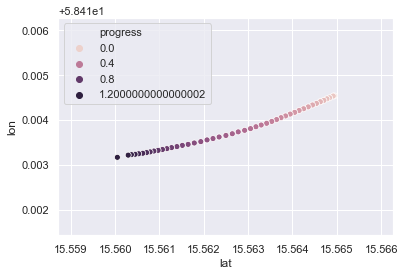

In [3]:
# this guys crashed the thing if priors are set: traj 11, seg 9 | traj 8, seg 3 | 35.0 2
crash_data = train[(train.traj == 35) & (train.seg == 2)]
print(crash_data)
sns.scatterplot(data = crash_data, x='lat', y='lon', hue='progress')

Let's plot some of the likelihood GPs to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


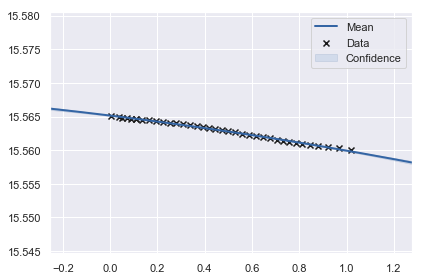

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


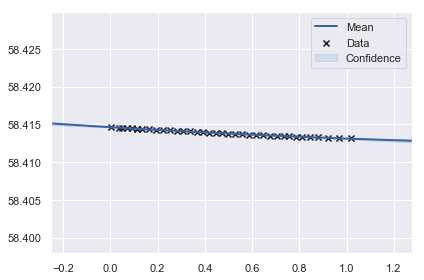

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


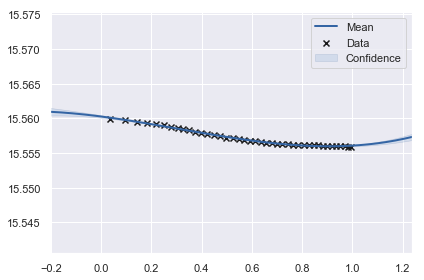

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


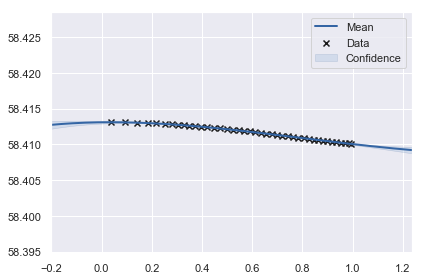

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


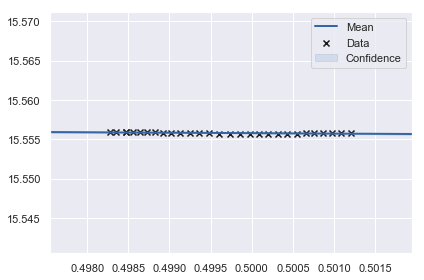

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


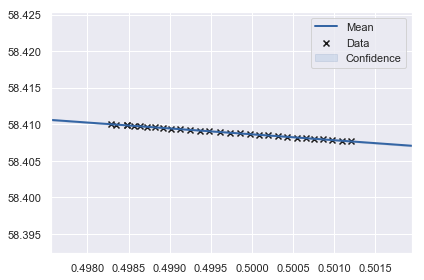

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


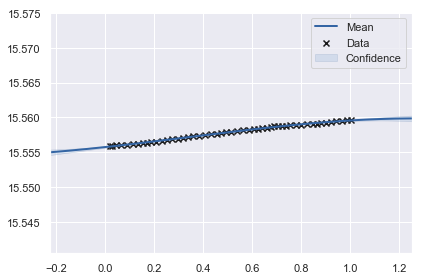

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


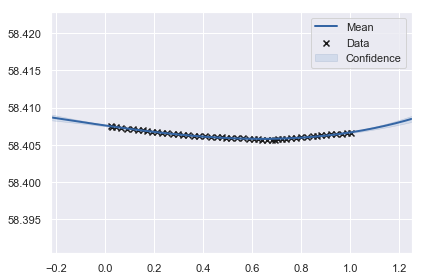

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


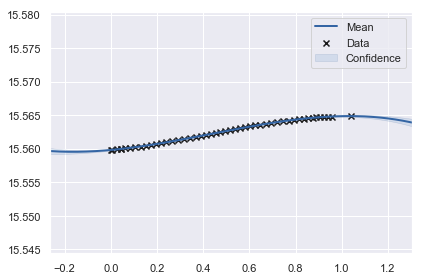

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


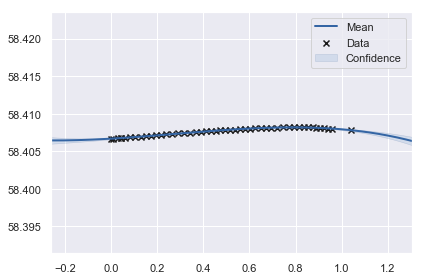

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


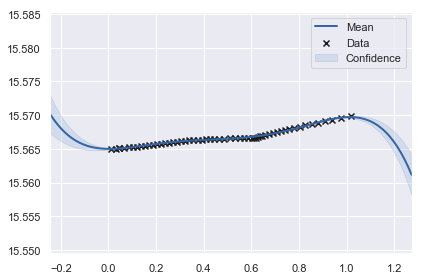

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


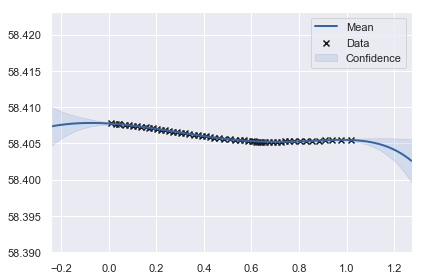

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


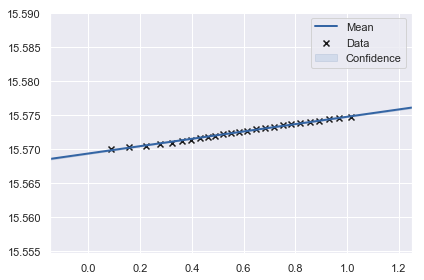

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


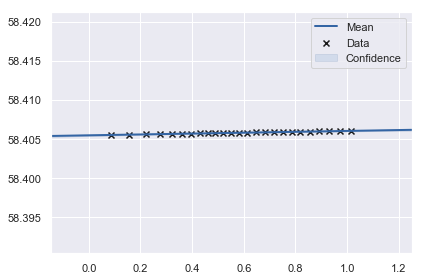

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


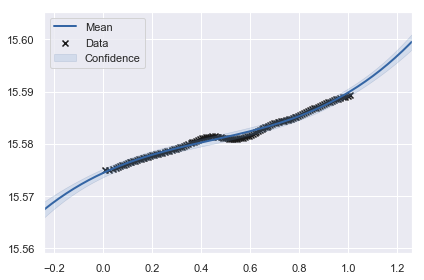

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


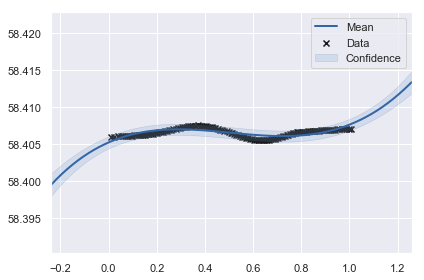

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


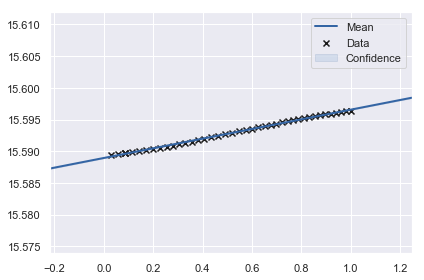

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


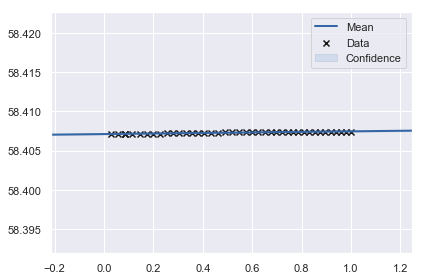

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


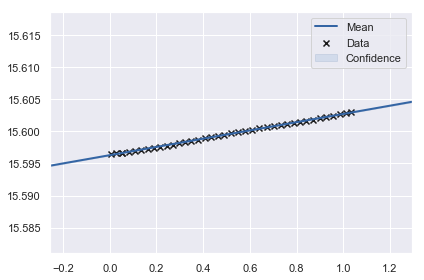

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


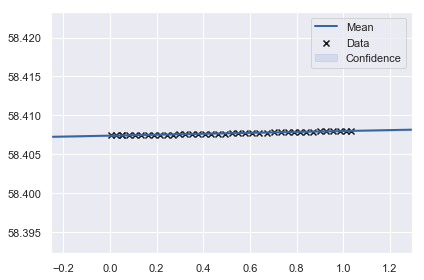

In [9]:
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    lik_model.model.plot(which_data_ycols=[0])
    lik_model.model.plot(which_data_ycols=[1])

Let's do the same for the predictive GP

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


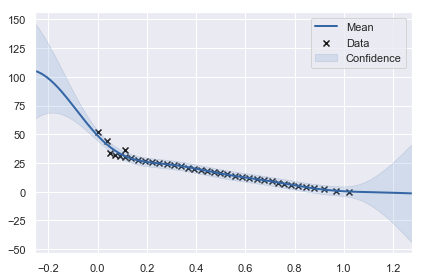

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


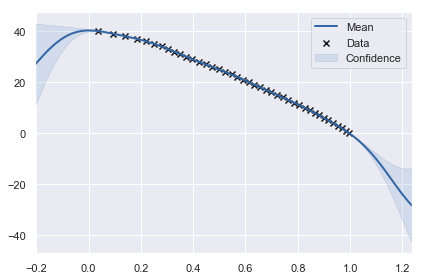

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


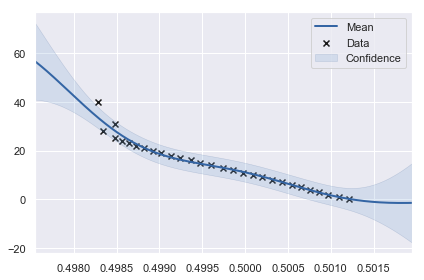

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


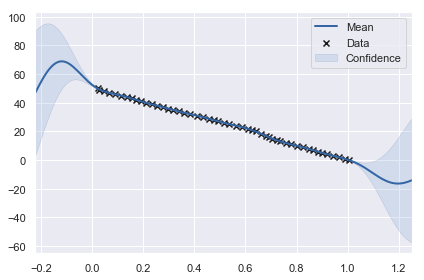

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


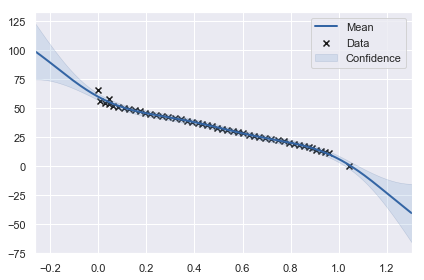

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


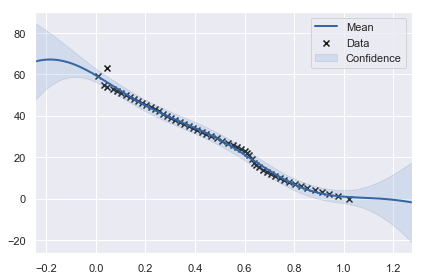

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


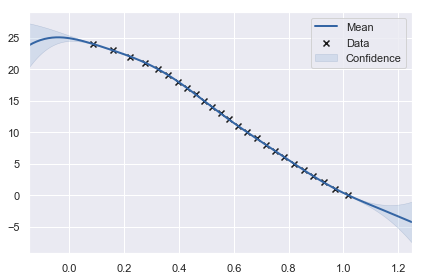

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


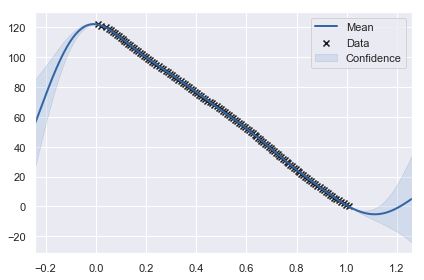

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


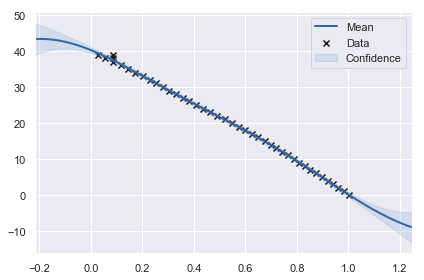

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


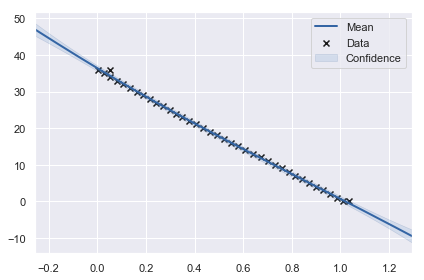

In [10]:
import GPy
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    pred_model.model.plot()

The results for both the GPs look really good. We'll save both do disk.

In [11]:
for models in traj_gps.values():
    for lik_model, pred_model in models.values():
        gp.save(lik_model)
        gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            lat        lon  traj  seg  speed  time_left  progress
2851  15.574347  58.405941   6.0    8   6.27       13.0  0.878788
2852  15.574444  58.405945   6.0    8   5.65       12.0  0.909091
2853  15.574532  58.405949   6.0    8   5.09       11.0  0.939394
2854  15.574614  58.405952   6.0    8   4.57       10.0  0.969697
2855  15.574796  58.405961   6.0    8   4.16        0.0  1.000000
pred: 27.97 true: 14.0 MAE: 13.97 MAPE: 1.00


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


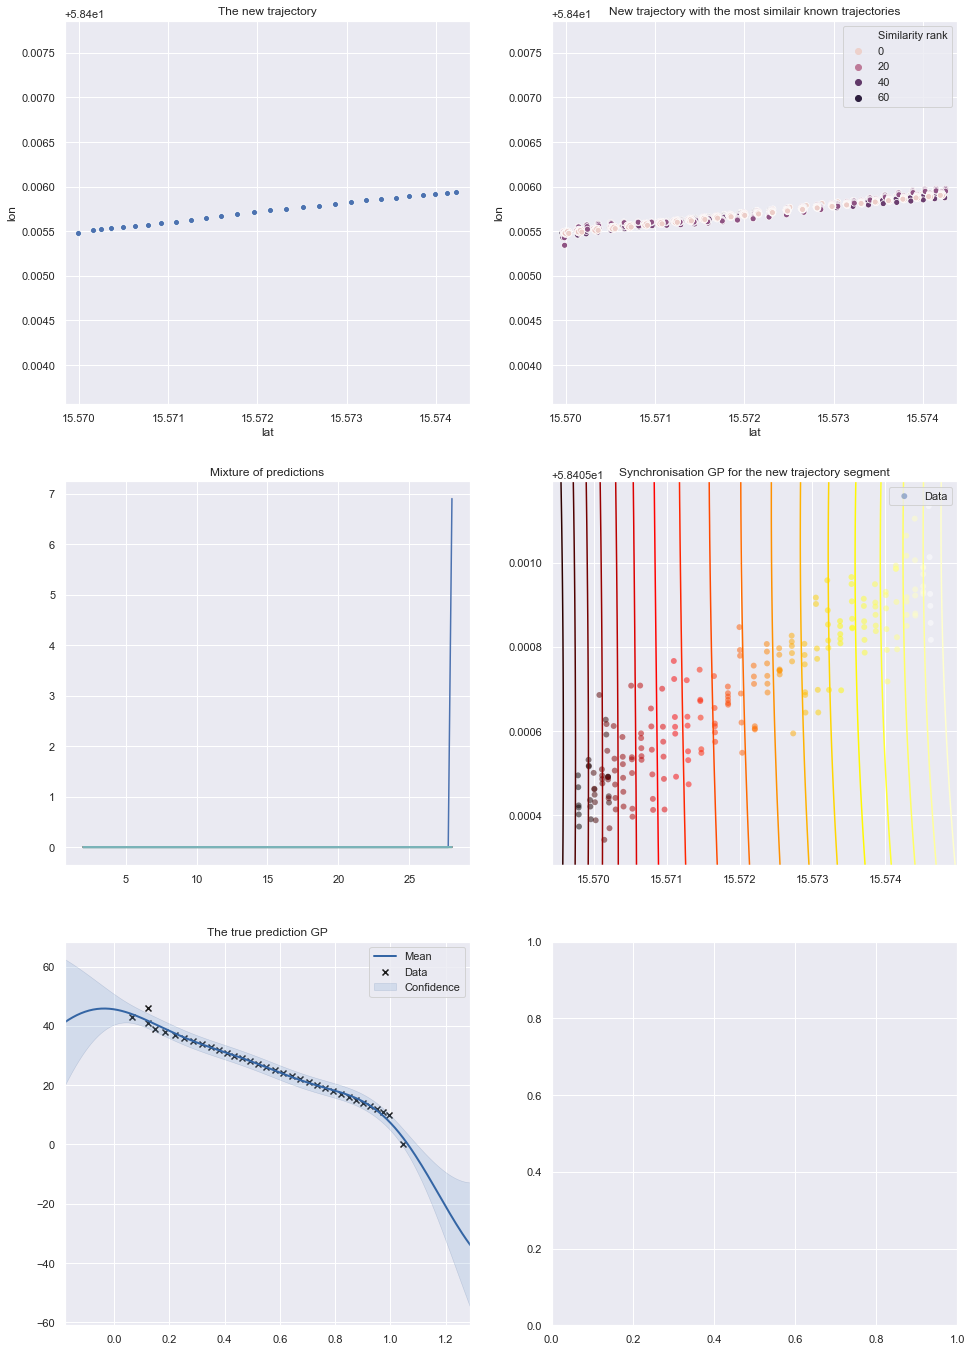

In [151]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_likelihood_models(models_by_loglik, synched_traj):
    X = synched_traj[['tau']].values
    
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
    n_models = len(models_by_loglik)
    dfs = [to_df(mloglik[0], n_models-i) for mloglik, i in zip(models_by_loglik, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y): 
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
    
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)

    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        n_models_to_use = 50
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)[0:n_models_to_use]
        max_loglik = models_by_loglik[0][1]

        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)

        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]

    synched_traj = synch_data(synch_gp, traj)
    lik_models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, plot)
    if plot:
        sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
        xmin = np.floor(float(sort[0][0]-sort[0][1]*3))
        xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
        n = 100
        xx = np.linspace(xmin, xmax, n)
        yy = [] # use for mixture mode
        for mean, var, w in mean_var_weights:
            y = w*scipy.stats.norm.pdf(xx, float(mean), np.sqrt(float(var)))
            yy.append(y)
            axs[1,0].plot(xx, y)
        axs[1,0].set_title('Mixture of predictions')
        
    models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    mode_model = int(np.ceil(np.argmax(yy)/n)-1)
    return float(mean_var_weights[mode_model][0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = train # pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
traj_n = n_test_trajs[4]
test_traj = test[test.traj == traj_n]
seg_ix = 6
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, traj_n, seg_n):
    i = test_seg.index[-1]-5 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n)
    pred = predict(seg, synch_gp, route_n, seg_n, plot=True)
    true = seg.iloc[-1].time_left
    #print(seg.tail())
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print(test_seg.tail())
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    
    pred_gp = gp.load(PREDICTION_MODEL, route_n, traj_n, seg_n)
    pred_gp.model.plot(ax=axs[2, 0])
    axs[2,0].set_title('The true prediction GP')
    
predict_seg_with_plots(test_seg, route_n, traj_n, seg_n)

Segments 1.0, 1.2, 1.4 are strange, does not seem to converge on one trajectory. Segment 4.2 has an 11 second jump at the final data point

In [ ]:
MAPE = []
MAE = []
for seg_n in test.seg.unique()[0:1]:
    seg = test[test.seg == seg_n]
    for traj_n in seg.traj.unique()[0:2]:
        traj = seg[seg.traj == traj_n]
        predict_seg(traj, route_n, seg_n, plot)
       

In [8]:

abs_errs = []
for traj_n in n_test_trajs:
    traj = test[test.traj == traj_n]
    n_traj_segs = traj.seg.unique()
    for seg_n in n_traj_segs[0:1]:
        seg = traj[traj.seg == seg_n]
        i = np.random.randint(seg.index[0], seg.index[-1]-1)
        seg = seg[seg.index < i]
        synch_gp = gp.load_synch(route_n, seg_n)
        pred = predict(seg, synch_gp, route_n, seg_n)
        true = test_seg.iloc[-1].time_left
        abs_errs.append(np.abs((true-pred)/true))

mape = np.mean(abs_errs)
mape

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:divide by zero encountered in double_scalars
 C:\Us

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
print(abs_errs)